# UK Property Image Classification
### EDA model 4a

---

#### Data:
Using exterior images only, 280 images each class (period vs modern)

#### Model:
Convoluted Neural Nets
- Use standard scaler
- Use early stopper
- Use dropout
- AUC as metrics

#### Model results:
AUC > 90%, accuracy > 80% (vs baseline 50%)


### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from math import ceil
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from skimage import io
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean

import pickle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# For reproducibility
np.random.seed(42)

In [4]:
# function to load folder into arrays and  then it returns that same array

def load_files(path):
    # Put files into lists and return them as one list of size 4
    image_files = os.listdir(path)
    image_files = [path + x for x in image_files]
    return image_files

In [5]:
# feeding images into numpy ndarray

def load_array(image_files, min_size):
    X = np.array([])
    for file in image_files:
        try:
            img = io.imread(file)
            img_resized = resize(img, (min_size,min_size), anti_aliasing=True)
            if X.shape[0] == 0:
                X = np.array([img_resized])
            else:
                X = np.append(X, [img_resized], axis = 0)
        
        except:
            print("image error: ", file)
    return X



In [6]:
def load_more_images(criteria, k):
    
    #default csv file of record
    csv = '../data/more_images.csv'
    images = pd.read_csv(csv)
    images.fillna(0, inplace=True)
    
    for key, value in criteria.items():
        images = images[images[key]==value]
    
    if k>len(images):
        print("Number of images is less than k")
    selected = random.choices(images["image_link"].to_list(), k=k)
    
    return selected

#### Load the training data - old buildings

In [7]:
# Photos of old or period buildings

image_path = "../images/old_samples/"
image_files = load_files(image_path)

# third batch - more images - 191 exterior
criteria = {"ext":1., "new":0.}
k=191
image_files2 = load_more_images(criteria, k)

# concatenating 2 lists
image_files = image_files + image_files2

# set min_size = 400
min_size = 400

print(f"number of image_files = {len(image_files)}")
print(f"min_size = {min_size}")

Number of images is less than k
number of image_files = 280
min_size = 400


In [8]:
image_files[-10:]

['../images/old_more/photo-14697656-2yAs3j.jpg',
 '../images/old_more/photo-14717258-xLtLDo.jpg',
 '../images/old_more/photo-14636469-dD53bQ.jpg',
 '../images/old_more/photo-14621564-FB5vqU.jpg',
 '../images/old_more/photo-14631080-PlIwgM.jpg',
 '../images/old_more/photo-14710827-9a01IX.jpg',
 '../images/modern_more/photo-14669029-cyHGCo.jpg',
 '../images/old_more/photo-14717189-ETIjoy.jpg',
 '../images/old_more/photo-14697626-e1RUI5.jpg',
 '../images/old_more/photo-14659361-Uvqw6T.jpg']

In [9]:
# record image links in dataframe
df_file_info = pd.DataFrame(image_files)
df_file_info.columns = ["image_link"]
print(f"df_file_info = {df_file_info.head(5)}")

df_file_info =                                         image_link
0  ../images/old_samples/photo-14610337-AfvlL7.jpg
1  ../images/old_samples/photo-14613473-oJlAGk.jpg
2  ../images/old_samples/photo-14613600-uzDqQq.jpg
3  ../images/old_samples/photo-14614603-V4bv1O.jpg
4  ../images/old_samples/photo-14615502-8O2X6l.jpg


In [10]:
X_old = load_array(image_files, min_size)

# y value is zero for old buildings
y_old = np.zeros((len(image_files),1))

print(f"X_old shape = {X_old.shape}")
print(f"y_old shape = {y_old.shape}")

c:\python37\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


X_old shape = (280, 400, 400, 3)
y_old shape = (280, 1)


In [11]:
df_y_old = pd.DataFrame(y_old, columns=["label"])
df_y_old["image_link"] = df_file_info["image_link"]
print(df_y_old.shape)

(280, 2)


In [12]:
# Photos of modern buildings

# first batch - modern exterior
image_path = "../images/modern_exterior/"
image_files = load_files(image_path)

# second batch - more images - 130 exterior
criteria = {"ext":1., "new":1.}
k=130
image_files2 = load_more_images(criteria, k)

# concatenating 2 lists
image_files = image_files + image_files2

# set min_size = 400
min_size = 400

print(f"number of image_files = {len(image_files)}")
print(f"min_size = {min_size}")

Number of images is less than k
number of image_files = 280
min_size = 400


In [13]:
# record image links in dataframe
df_file_info = pd.DataFrame(image_files)
df_file_info.columns = ["image_link"]
print(f"df_file_info = {df_file_info.head(5)}")

df_file_info =                                           image_link
0  ../images/modern_exterior/photo-14723285-Ij1qL...
1  ../images/modern_exterior/photo-14723721-06TtP...
2  ../images/modern_exterior/photo-14723756-sqnnq...
3  ../images/modern_exterior/photo-14723762-tK2Vv...
4  ../images/modern_exterior/photo-14723907-wPr2I...


In [14]:
X_modern = load_array(image_files, min_size)

# y value is one for modern buildings
y_modern = np.ones((len(image_files),1))

print(f"X_modern shape = {X_modern.shape}")
print(f"y_modern shape = {y_modern.shape}")

X_modern shape = (280, 400, 400, 3)
y_modern shape = (280, 1)


In [15]:
df_y_modern = pd.DataFrame(y_modern, columns=["label"])
df_y_modern["image_link"] = df_file_info["image_link"]
print(df_y_modern.shape)

(280, 2)


In [16]:
X = np.append(X_old, X_modern, axis = 0)
X.shape

(560, 400, 400, 3)

In [17]:
np.min(X)

0.0

In [18]:
np.max(X)

1.0

Note: range of values is 0 to 1; ie min max standard scaling in place

In [19]:
df_y = pd.concat([df_y_old, df_y_modern])
df_y.reset_index(drop=True, inplace=True)
df_y["id"] = df_y.index
print(df_y.shape)
df_y.tail(10)

(560, 3)


,label,image_link,id
550,1.0,../images/modern_more/photo-14658279-JNNHVO.jpg,550
551,1.0,../images/modern_more/photo-14636197-OFKCCi.jpg,551
552,1.0,../images/modern_more/photo-14700104-GGoPNk.jpg,552
553,1.0,../images/modern_more/photo-14648646-kGghwk.jpg,553
554,1.0,../images/modern_more/photo-14705536-Kn4Tz1.jpg,554
555,1.0,../images/modern_more/photo-14640121-NG4ZiN.jpg,555
556,1.0,../images/modern_more/photo-14669096-5NlA3c.jpg,556
557,1.0,../images/modern_more/photo-14648646-kGghwk.jpg,557
558,1.0,../images/old_more/photo-14649223-Z5IZgV.jpg,558
559,1.0,../images/modern_more/photo-14672333-7oUGIo.jpg,559


#### Train test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, df_y, stratify=df_y["label"])
print(y_train.shape)

(420, 3)


In [21]:
# Baseline accuracy - 50%
y_train['label'].value_counts()

1.0    210
0.0    210
Name: label, dtype: int64

In [22]:
y_test.shape

(140, 3)

In [23]:
y_test['id'][:10]

129    129
455    455
207    207
133    133
376    376
328    328
407    407
149    149
473    473
17      17
Name: id, dtype: int64

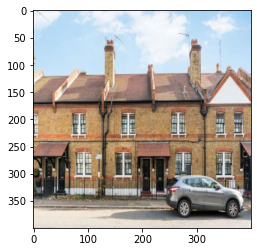

In [24]:
plt.imshow(X_train[0])

#### Standard Scaler

In [25]:
X_train_flat = X_train.flatten().reshape(-1,1)
X_train_flat.shape

(201600000, 1)

In [26]:
X_test_flat = X_test.flatten().reshape(-1,1)
X_test_flat.shape

(67200000, 1)

In [27]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_ss = ss.transform(X_test_flat).reshape(X_test.shape)

X_train_ss = X_train
X_test_ss = X_test

### CNN model

In [35]:
# Instantiate a CNN.
cnn_model = Sequential()

In [36]:
# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,            # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(min_size,min_size,3))) # shape of input (image)

In [37]:
cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling
cnn_model.add(Conv2D(16,
                     kernel_size=3,
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))
# Dropout layer
cnn_model.add(Dropout(0.5))
# Add a final layer with 2 neurons.
cnn_model.add(Dense(1, activation='sigmoid'))

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Compile model
# cnn_model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [38]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 398, 398, 6)       168       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 199, 199, 6)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 197, 197, 16)      880       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 153664)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19669120  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [39]:
# Fit model on training data
history = cnn_model.fit(X_train_ss,
                        y_train['label'],
                        batch_size=64,
                        validation_data=(X_test_ss, y_test['label']),
                        epochs=30,
                        callbacks=[es],
                        verbose=1)

Epoch 1/30
7/7 [==============================] - 29s 3s/step - loss: 4.8582 - auc: 0.5074 - val_loss: 0.7939 - val_auc: 0.7939
Epoch 2/30
7/7 [==============================] - 17s 2s/step - loss: 1.5959 - auc: 0.5663 - val_loss: 0.5891 - val_auc: 0.8372
Epoch 3/30
7/7 [==============================] - 16s 2s/step - loss: 0.5922 - auc: 0.7751 - val_loss: 0.5698 - val_auc: 0.8512
Epoch 4/30
7/7 [==============================] - 17s 2s/step - loss: 0.5126 - auc: 0.8587 - val_loss: 0.5576 - val_auc: 0.8557
Epoch 5/30
7/7 [==============================] - 17s 2s/step - loss: 0.3853 - auc: 0.9361 - val_loss: 0.4880 - val_auc: 0.8638
Epoch 6/30
7/7 [==============================] - 16s 2s/step - loss: 0.3141 - auc: 0.9565 - val_loss: 0.4399 - val_auc: 0.8849
Epoch 7/30
7/7 [==============================] - 16s 2s/step - loss: 0.1991 - auc: 0.9913 - val_loss: 0.4087 - val_auc: 0.8973
Epoch 8/30
7/7 [==============================] - 17s 2s/step - loss: 0.1260 - auc: 0.9944 - val_loss: 0

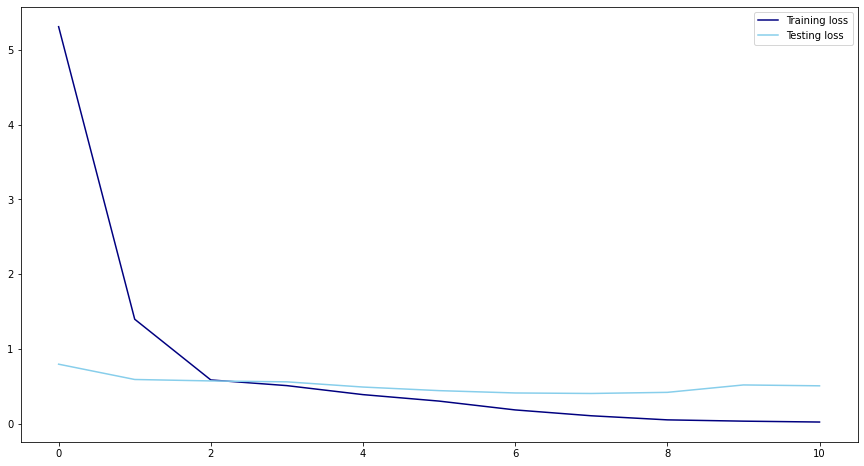

In [43]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(15, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### List out the images of misclassification - test images

In [44]:
y_test.head(10)

,label,image_link,id
129,0.0,../images/old_more/photo-14706149-rgNNf1.jpg,129
455,1.0,../images/modern_more/photo-14635210-915ZiC.jpg,455
207,0.0,../images/old_more/photo-14629239-JKDsFL.jpg,207
133,0.0,../images/old_more/photo-14621525-4hL0JX.jpg,133
376,1.0,../images/modern_exterior/photo-14743296-VxaFx...,376
328,1.0,../images/modern_exterior/photo-14728948-DDhZK...,328
407,1.0,../images/modern_exterior/photo-14746724-PD2Mi...,407
149,0.0,../images/old_more/photo-14669867-c6dDk8.jpg,149
473,1.0,../images/modern_more/photo-14645607-fIbzBy.jpg,473
17,0.0,../images/old_samples/photo-14639139-0umZNo.jpg,17


In [45]:
y_pred = cnn_model.predict(X_test_ss)


In [46]:
y_pred.shape

(140, 1)

In [47]:
y_test['pred'] = y_pred.round()
y_test['prob'] = y_pred.round(3)
y_test.head(10)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,image_link,id,pred,prob
129,0.0,../images/old_more/photo-14706149-rgNNf1.jpg,129,0.0,0.002
455,1.0,../images/modern_more/photo-14635210-915ZiC.jpg,455,0.0,0.407
207,0.0,../images/old_more/photo-14629239-JKDsFL.jpg,207,0.0,0.003
133,0.0,../images/old_more/photo-14621525-4hL0JX.jpg,133,0.0,0.001
376,1.0,../images/modern_exterior/photo-14743296-VxaFx...,376,1.0,1.000
328,1.0,../images/modern_exterior/photo-14728948-DDhZK...,328,1.0,1.000
407,1.0,../images/modern_exterior/photo-14746724-PD2Mi...,407,1.0,0.956
149,0.0,../images/old_more/photo-14669867-c6dDk8.jpg,149,0.0,0.000
473,1.0,../images/modern_more/photo-14645607-fIbzBy.jpg,473,1.0,0.993
17,0.0,../images/old_samples/photo-14639139-0umZNo.jpg,17,1.0,0.934


#### Images properly classified

In [57]:
# count the number of photos classified properly in y_test
y_test_classified = y_test[["image_link", "label", "pred", "prob"]][y_test["label"] == y_test["pred"]]

print(f"total number in y_test: {y_test.shape[0]}")
print(f"classified properly in y_test: {y_test_classified.shape[0]}")
y_test_classified.head()

print(f"accuracy: {round(y_test_classified.shape[0]/y_test.shape[0],3)}")


total number in y_test: 140
classified properly in y_test: 114
accuracy: 0.814


20


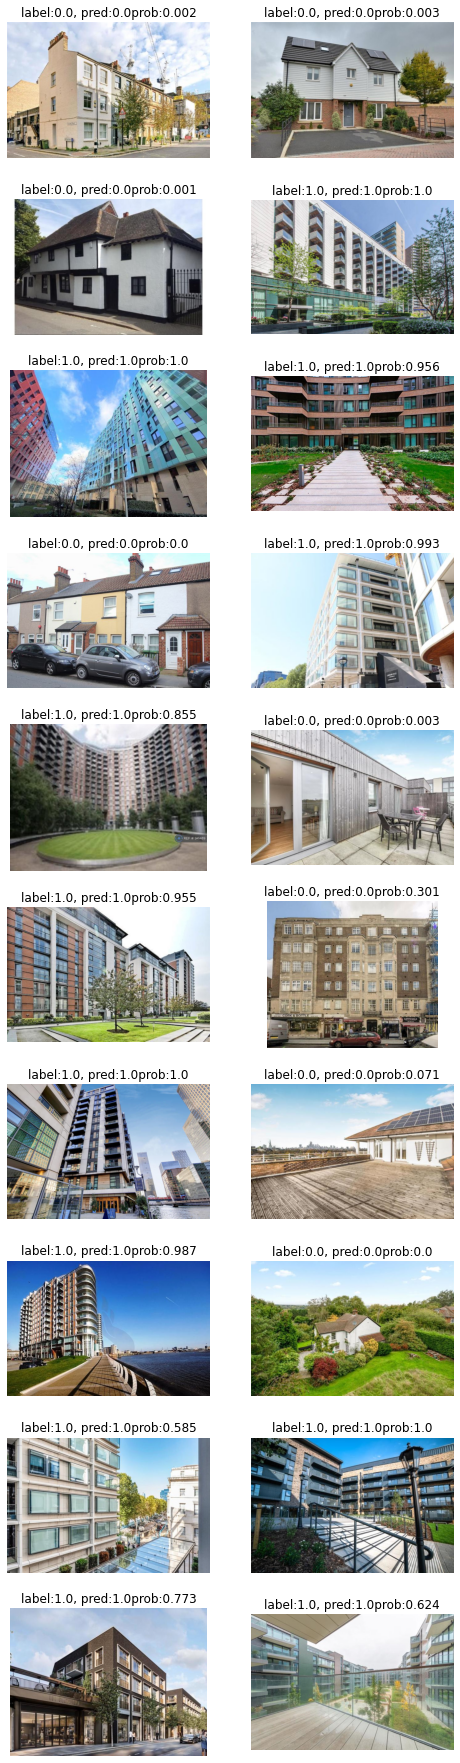

In [50]:
# show the first 20 photos classified properly in y_test
display_no = min(20, y_test_classified.shape[0])

fig, ax = plt.subplots(ceil(display_no/2), 2, figsize=(8,32))
j=0
for i in y_test_classified.index[:display_no]:
    row = j//2
    col = j%2
    image_link = y_test_classified.loc[i, "image_link"]
    ax[row][col].imshow(io.imread(image_link))
    ax[row][col].set_title("label:" + str(y_test_classified.loc[i, "label"]) + ", pred:" + str(y_test_classified.loc[i, "pred"]) + "prob:"  + str(y_test_classified.loc[i, "prob"]))
    ax[row][col].axis('off')
    j += 1

print(j)

#### Images misclassified

In [51]:
# count the number of photos misclassified in y_test
y_test_misclassified = y_test[["image_link", "label", "pred", "prob"]][y_test["label"] != y_test["pred"]]

print(f"total number in y_test: {y_test.shape[0]}")
print(f"misclassified in y_test: {y_test_misclassified.shape[0]}")
y_test_misclassified.head()



total number in y_test: 140
misclassified in y_test: 26


,image_link,label,pred,prob
455,../images/modern_more/photo-14635210-915ZiC.jpg,1.0,0.0,0.407
17,../images/old_samples/photo-14639139-0umZNo.jpg,0.0,1.0,0.934
509,../images/modern_more/photo-14696307-5aDQ8i.jpg,1.0,0.0,0.435
538,../images/modern_more/photo-14631118-EgpwsG.jpg,1.0,0.0,0.191
53,../images/old_samples/photo-14682417-cxQLis.jpg,0.0,1.0,0.969


20


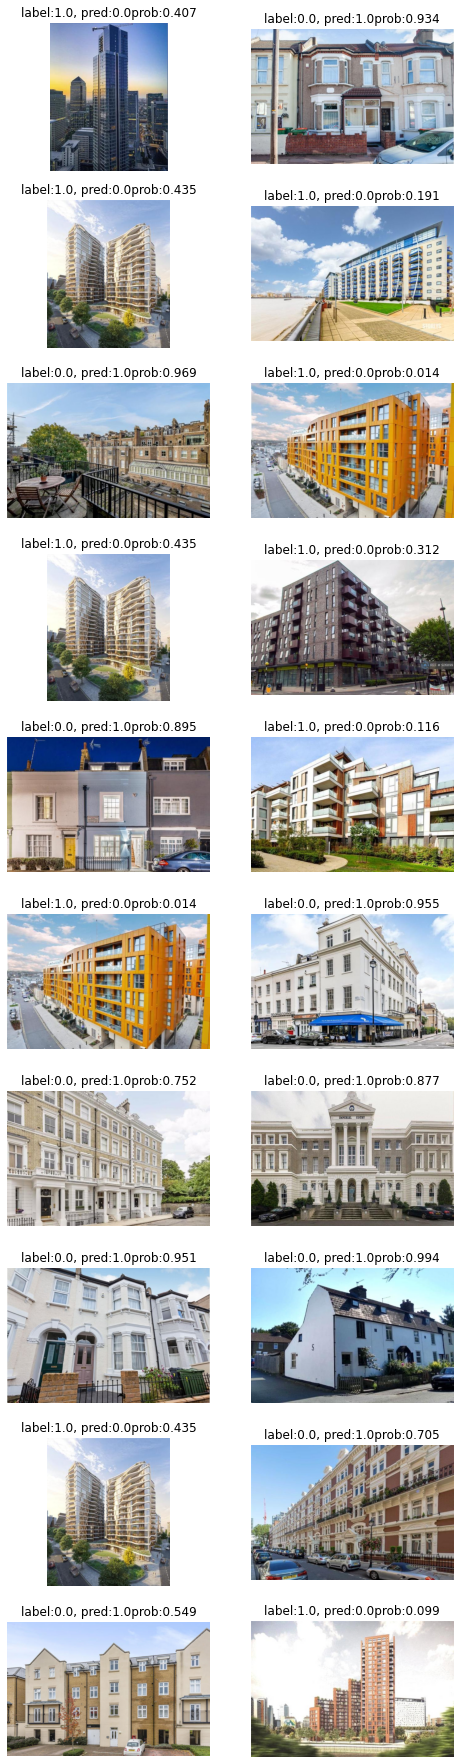

In [52]:
# show the first 20 photos misclassified in y_test
display_no = min(20, y_test_misclassified.shape[0])

fig, ax = plt.subplots(ceil(display_no/2), 2, figsize=(8,32))
j=0
for i in y_test_misclassified.index[:display_no]:
    row = j//2
    col = j%2
    image_link = y_test_misclassified.loc[i, "image_link"]
    ax[row][col].imshow(io.imread(image_link))
    ax[row][col].set_title("label:" + str(y_test_misclassified.loc[i, "label"]) + ", pred:" + str(y_test_misclassified.loc[i, "pred"]) + "prob:"  + str(y_test_misclassified.loc[i, "prob"]))
    ax[row][col].axis('off')
    j += 1

print(j)

### Saving the model

In [53]:
model_tag = "model4a"

In [54]:
# Save the model
model = cnn_model

path = '../models/' + model_tag + '/'
model.save(path)


INFO:tensorflow:Assets written to: ../models/model4a/assets


In [55]:
# save the scaler
pickle.dump(ss, open('../models/' + model_tag + '/scaler.pkl', 'wb'))

In [60]:
y_test

,label,image_link,id,pred,prob
129,0.0,../images/old_more/photo-14706149-rgNNf1.jpg,129,0.0,0.002
455,1.0,../images/modern_more/photo-14635210-915ZiC.jpg,455,0.0,0.407
207,0.0,../images/old_more/photo-14629239-JKDsFL.jpg,207,0.0,0.003
133,0.0,../images/old_more/photo-14621525-4hL0JX.jpg,133,0.0,0.001
376,1.0,../images/modern_exterior/photo-14743296-VxaFx...,376,1.0,1.000
...,...,...,...,...,...
20,0.0,../images/old_samples/photo-14639242-VynKBb.jpg,20,1.0,0.741
297,1.0,../images/modern_exterior/photo-14726439-g7cop...,297,1.0,0.993
391,1.0,../images/modern_exterior/photo-14745120-cS8VP...,391,1.0,0.765
7,0.0,../images/old_samples/photo-14622750-kpCpOD.jpg,7,0.0,0.011


In [64]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test["label"], y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

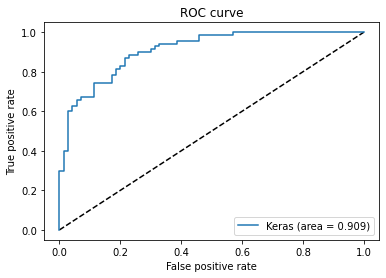

In [66]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()